# Tile Rubin ECDFS (overlapping) and save per-tile center RA/Dec + WCS

In [27]:
import os, glob
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom

# ---- Config ----
OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
os.makedirs(OUT_RUBIN_DIR, exist_ok=True)

bands_rubin = ("u","g","r","i","z","y")
TILE_SIZE = 512
STRIDE    = 256    # overlap
MAX_TILES = None   # None => all tiles in that patch image

# ECDFS rough center (good enough to land on the right patch; you already validated visually)
ra_ecdfs  = 53.16
dec_ecdfs = -28.10

REPO="dp1"
COLLECTION="LSSTComCam/DP1"
DATASETTYPE="deep_coadd"


def get_one_deep_coadd_ref(butler, ra, dec, band, datasetType="deep_coadd"):
    refs = list(butler.query_datasets(
        datasetType,
        where="band.name = band AND patch.region OVERLAPS POINT(ra, dec)",
        bind={"band": band, "ra": ra, "dec": dec},
        with_dimension_records=True,
        order_by=["patch.tract"],
    ))
    if not refs:
        raise RuntimeError(f"No {datasetType} found for band={band} at ra,dec={ra},{dec}")
    return refs[0]


def load_patch_exposures(ra, dec, bands=bands_rubin, repo=REPO, collection=COLLECTION, datasetType=DATASETTYPE):
    butler = Butler(repo, collections=collection)
    ref0 = get_one_deep_coadd_ref(butler, ra, dec, bands[0], datasetType=datasetType)
    base_dataId = dict(ref0.dataId.mapping)

    exps = {}
    for b in bands:
        dataId = dict(base_dataId)
        dataId["band"] = b
        exps[b] = butler.get(datasetType, dataId=dataId)

    # full-patch WCS (pixel coords of the big coadd)
    wcs_full = exps[bands[0]].getWcs()
    return exps, wcs_full, base_dataId


def wcs_to_hdr_dict_lsst(wcs_lsst):
    md = wcs_lsst.getFitsMetadata()
    return {k: md.getScalar(k) for k in md.names()}

def tile_patch_and_save(exps, wcs_full, out_dir, tile_size=TILE_SIZE, stride=STRIDE, bands=bands_rubin, max_tiles=MAX_TILES):
    os.makedirs(out_dir, exist_ok=True)
    
    # --- FIX 1: Get the Patch's internal pixel origin ---
    # This is critical. The array [0,0] is actually at [x0_patch, y0_patch] in the WCS
    patch_origin = exps[bands[0]].getXY0()
    x0_patch = patch_origin.getX()
    y0_patch = patch_origin.getY()
    
    H, W = exps[bands[0]].image.array.shape
    n_saved = 0

    for y0 in range(0, H - tile_size + 1, stride):
        for x0 in range(0, W - tile_size + 1, stride):
            
            # --- FIX 2: Calculate center using TRUE GLOBAL coordinates ---
            # We add the patch origin to our local loop indices
            global_cx = x0_patch + x0 + (tile_size - 1) / 2.0
            global_cy = y0_patch + y0 + (tile_size - 1) / 2.0
            
            sp_global = wcs_full.pixelToSky(global_cx, global_cy)
            ra_c  = sp_global.getRa().asDegrees()
            dec_c = sp_global.getDec().asDegrees()

            # --- FIX 3: Local WCS for the tile ---
            # The local (0,0) of this tile is at (x0_patch + x0) in the WCS
            wcs_local = wcs_full.copyAtShiftedPixelOrigin(geom.Extent2D(-(x0_patch + x0), -(y0_patch + y0)))

            # --- 3. DATA EXTRACTION ---
            imgs, vars_, masks = [], [], []
            for b in bands:
                exp = exps[b]
                img = exp.image.array[y0:y0+tile_size, x0:x0+tile_size].astype(np.float32)
                var = exp.variance.array[y0:y0+tile_size, x0:x0+tile_size].astype(np.float32)
                msk = exp.mask.array[y0:y0+tile_size, x0:x0+tile_size].astype(np.int32)
                
                imgs.append(img)
                vars_.append(var)
                masks.append(msk)

            imgs_stacked  = np.stack(imgs,  axis=0)
            vars_stacked  = np.stack(vars_, axis=0)
            masks_stacked = np.stack(masks, axis=0)

            # --- 4. SAVE ---
            tile_id = f"tile_x{x0:05d}_y{y0:05d}"
            fn = os.path.join(out_dir, f"{tile_id}.npz")

            np.savez_compressed(
                fn,
                img=imgs_stacked, 
                var=vars_stacked, 
                mask=masks_stacked,
                wcs_hdr=wcs_to_hdr_dict_lsst(wcs_local),
                x0=np.int32(x0), y0=np.int32(y0),
                tile_id=np.bytes_(tile_id),
                ra_center=np.float64(ra_c), 
                dec_center=np.float64(dec_c),
                tile_size=np.int32(tile_size), 
                stride=np.int32(stride),
                bands=np.array(list(bands)),
            )

            n_saved += 1
            if (max_tiles is not None) and (n_saved >= max_tiles):
                return n_saved
                
    return n_saved
# ---- Run Rubin tiling for ECDFS ----
exps, wcs_full, dataId0 = load_patch_exposures(ra_ecdfs, dec_ecdfs)
print("[ECDFS] Using patch:", dataId0)

n = tile_patch_and_save(exps, wcs_full, out_dir=OUT_RUBIN_DIR)
print("Saved Rubin tiles:", n, "->", OUT_RUBIN_DIR)


[ECDFS] Using patch: {'band': 'u', 'skymap': 'lsst_cells_v1', 'tract': 5063, 'patch': 14}
Saved Rubin tiles: 144 -> ../data/rubin_tiles_ecdfs


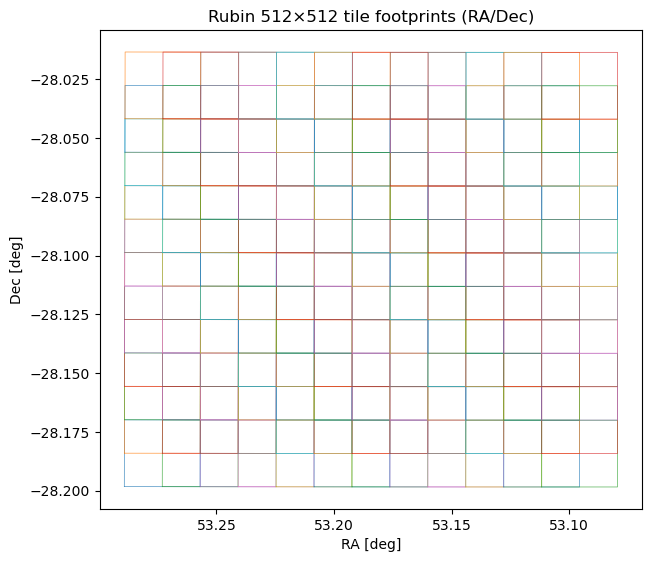

In [28]:
import lsst.afw.geom as afwGeom
from lsst.daf.base import PropertySet
import numpy as np
import glob
import matplotlib.pyplot as plt


def wcs_from_hdr_dict(hdr_dict):
    ps = PropertySet()
    for k, v in hdr_dict.items():
        ps.set(k, v)
    return afwGeom.makeSkyWcs(ps)


def tile_corners_from_npz(npz_path):
    d = np.load(npz_path, allow_pickle=True)

    wcs = wcs_from_hdr_dict(d["wcs_hdr"].item())
    tile_size = int(d["tile_size"])

    S = tile_size - 1
    corners_pix = [
        (0,   0),
        (S,   0),
        (S,   S),
        (0,   S),
        (0,   0),   # close polygon
    ]

    ra, dec = [], []
    for x, y in corners_pix:
        sp = wcs.pixelToSky(x, y)
        ra.append(sp.getRa().asDegrees())
        dec.append(sp.getDec().asDegrees())

    return np.array(ra), np.array(dec)

OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
files = sorted(glob.glob(f"{OUT_RUBIN_DIR}/tile_*.npz"))

plt.figure(figsize=(7,7))

for fn in files:
    ra, dec = tile_corners_from_npz(fn)
    plt.plot(ra, dec, linewidth=0.5, alpha=0.8)

plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Rubin 512×512 tile footprints (RA/Dec)")

# astronomy convention
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")

plt.show()


# For each Rubin tile, fetch Euclid VIS + Y/J/H and save with the same tile_id

In [29]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.geom as afwGeom

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astroquery.ipac.irsa import Irsa
import fsspec

from scipy.optimize import linear_sum_assignment
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter, median_filter, zoom
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.coordinates import match_coordinates_sky
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from astropy.coordinates import search_around_sky


def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

def save_bundle(path, **kw):
    np.savez_compressed(path, **{k: v for k, v in kw.items() if v is not None})
    print("saved:", path)


def load_euclid_cutouts(
    ra, dec, size_arcsec,
    bands=("VIS", "Y", "J", "H"),
    collection="euclid_DpdMerBksMosaic",
    radius_arcsec=60,
):
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
    # REMOVED .to_table() here
    tab = Irsa.query_sia(pos=(coord, radius_arcsec * u.arcsec), collection=collection)
    
    # If it's a list or a specialized result, ensure it's a table
    from astropy.table import Table
    if not isinstance(tab, Table):
        tab = tab.to_table()

    if "dataproduct_subtype" in tab.colnames:
        tab = tab[tab["dataproduct_subtype"] == "science"]

    out = {b: None for b in bands}
    wcs_out = {}

    for b in bands:
        # Some tables use 'energy_bandpassname', others might use different keys
        mask = tab["energy_bandpassname"] == b
        rows = tab[mask]
        
        if len(rows) == 0:
            continue

        url = rows["access_url"][0]

        with fsspec.open(url, "rb") as f:
            with fits.open(f, memmap=False) as hdul:
                # Euclid files usually have data/WCS in extension 0 or 1
                # Checking extension 0 for standard SIA results
                wcs0 = WCS(hdul[0].header)
                cut = Cutout2D(hdul[0].data, coord, size_arcsec * u.arcsec, wcs=wcs0)
                out[b] = np.array(cut.data, dtype=np.float32)
                wcs_out[b] = cut.wcs

    return out, wcs_out

# ---- Config ----
IN_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
OUT_EUCLID_DIR = "../data/euclid_tiles_ecdfs"
os.makedirs(OUT_EUCLID_DIR, exist_ok=True)

# Euclid bands you want
bands_euclid = ("VIS", "Y", "J", "H")
# Rubin pixel scale is ~0.2". 512 pixels * 0.2" = 102.4"
# We add a small buffer (e.g., 105") to ensure full coverage
EUCLID_SIZE_ARCSEC = 105.0 

def process_euclid_for_rubin_tiles():
    # 1. Find all saved Rubin tiles
    rubin_files = sorted(glob.glob(os.path.join(IN_RUBIN_DIR, "*.npz")))
    print(f"Found {len(rubin_files)} Rubin tiles. Fetching Euclid counterparts...")

    for r_file in rubin_files:
        # 1. Load Rubin tile metadata
        with np.load(r_file) as data:
            ra_c = float(data['ra_center'])
            dec_c = float(data['dec_center'])
            raw_id = data['tile_id']
            if isinstance(raw_id, (np.ndarray, np.bytes_, bytes)):
                tile_id = raw_id.item().decode('utf-8')
            else:
                tile_id = str(raw_id)
            
        out_fn = os.path.join(OUT_EUCLID_DIR, f"{tile_id}_euclid.npz")
        
        # Skip if already exists
        if os.path.exists(out_fn):
            continue

        try:
            # 3. Fetch Euclid data using your existing function
            # We use the RA/Dec center of the Rubin tile
            eu_imgs, eu_wcss = load_euclid_cutouts(
                ra_c, dec_c, 
                size_arcsec=EUCLID_SIZE_ARCSEC,
                bands=bands_euclid
            )

            # 4. Prepare arrays for saving (stacking bands)
            # Note: Euclid VIS and NISP have different pixel scales, 
            # so we store them in a dict or save individual arrays.
            # Here we save as a bundle to match your save_bundle logic.
            
            save_dict = {
                "ra_center": ra_c,
                "dec_center": dec_c,
                "tile_id": tile_id,
            }
            
            for b in bands_euclid:
                if eu_imgs[b] is not None:
                    save_dict[f"img_{b}"] = eu_imgs[b]
                    # Convert Astropy WCS to header string
                    save_dict[f"wcs_{b}"] = eu_wcss[b].to_header_string()

            np.savez_compressed(out_fn, **save_dict)
            print(f"Saved Euclid match for {tile_id}")

        except Exception as e:
            print(f"Failed to fetch Euclid for {tile_id}: {e}")

# Run the process
process_euclid_for_rubin_tiles()

Found 144 Rubin tiles. Fetching Euclid counterparts...
Saved Euclid match for tile_x00000_y00000
Saved Euclid match for tile_x00000_y00256
Saved Euclid match for tile_x00000_y00512
Saved Euclid match for tile_x00000_y00768
Saved Euclid match for tile_x00000_y01024
Saved Euclid match for tile_x00000_y01280
Saved Euclid match for tile_x00000_y01536
Saved Euclid match for tile_x00000_y01792
Saved Euclid match for tile_x00000_y02048
Saved Euclid match for tile_x00000_y02304
Saved Euclid match for tile_x00000_y02560
Saved Euclid match for tile_x00000_y02816
Saved Euclid match for tile_x00256_y00000
Saved Euclid match for tile_x00256_y00256
Saved Euclid match for tile_x00256_y00512
Saved Euclid match for tile_x00256_y00768
Saved Euclid match for tile_x00256_y01024
Saved Euclid match for tile_x00256_y01280
Saved Euclid match for tile_x00256_y01536
Saved Euclid match for tile_x00256_y01792
Saved Euclid match for tile_x00256_y02048
Saved Euclid match for tile_x00256_y02304
Saved Euclid match fo

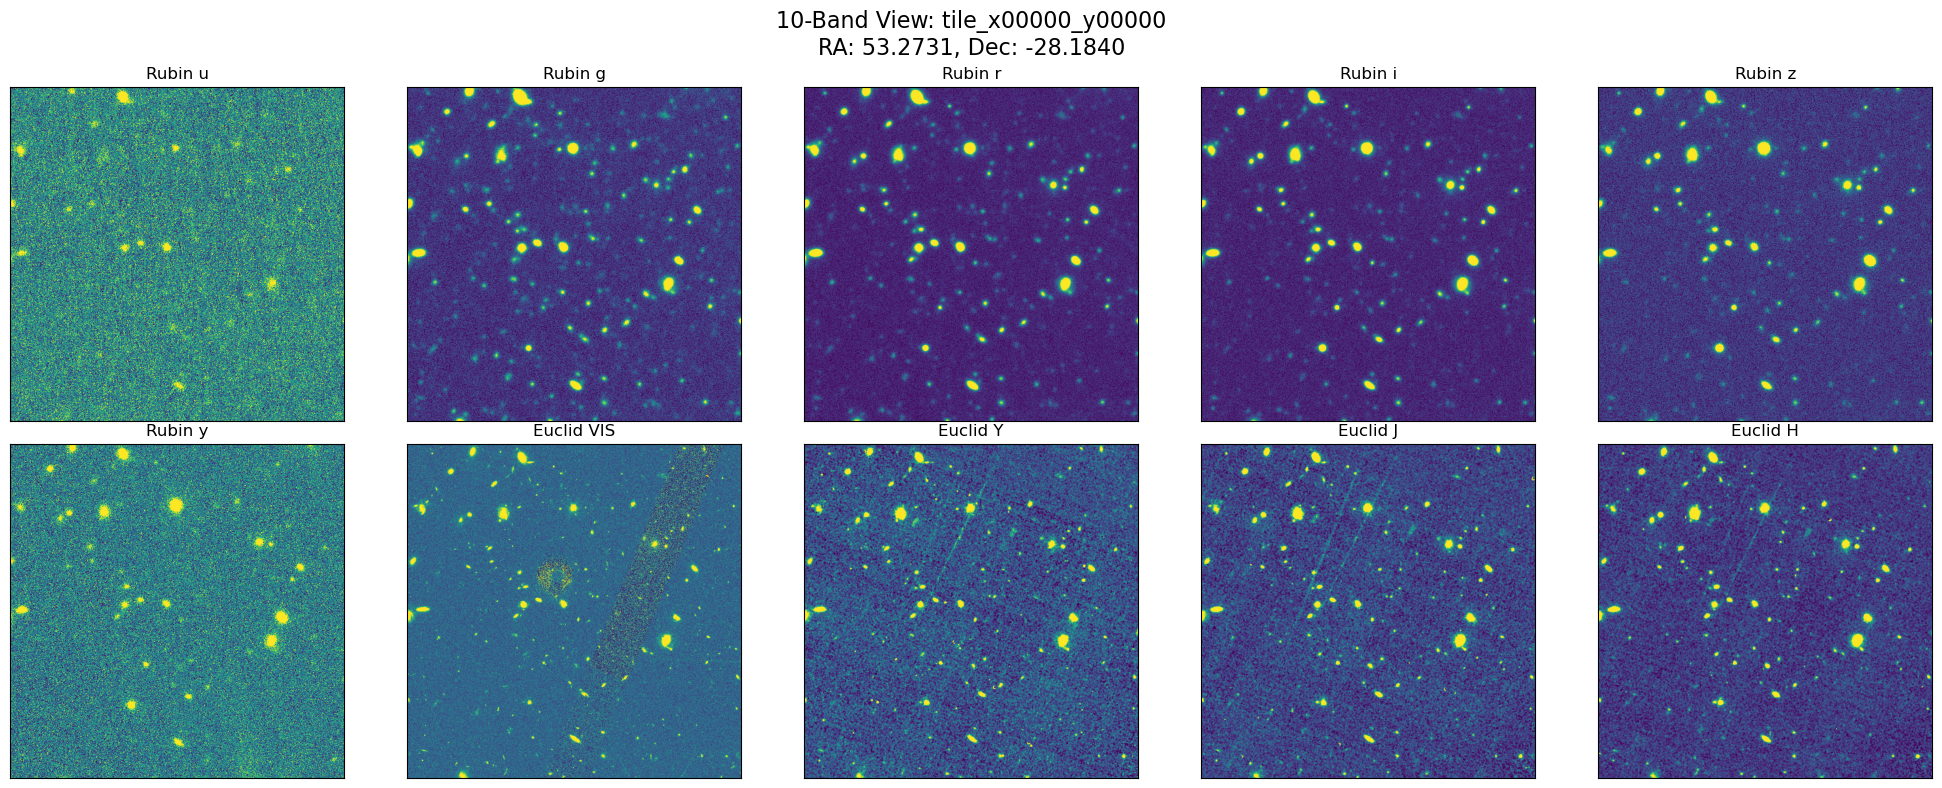

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

# ---- Path Configuration ----
tile_id_str = "tile_x00000_y00000"
rubin_path  = os.path.join(OUT_RUBIN_DIR,  f"{tile_id_str}.npz")
euclid_path = os.path.join(OUT_EUCLID_DIR, f"{tile_id_str}_euclid.npz")

# 1. Load Data
r_data = np.load(rubin_path)
e_data = np.load(euclid_path)

# Bands Mapping
# Rubin: u, g, r, i, z, y (indices 0-5)
# Euclid: VIS, Y, J, H
rubin_bands = ["u", "g", "r", "i", "z", "y"]
euclid_bands = ["VIS", "Y", "J", "H"]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 2. Plot Rubin Bands (Top Row + 1st of Bottom)
for i, band in enumerate(rubin_bands):
    ax = axes[i]
    img = r_data['img'][i]
    robust_imshow(ax, img, title=f"Rubin {band}")

# 3. Plot Euclid Bands (Remaining 4 slots)
for i, band in enumerate(euclid_bands):
    ax = axes[i + 6] # Start at index 6
    img_key = f"img_{band}"
    
    if img_key in e_data:
        img = e_data[img_key]
        # We can also parse the WCS if needed:
        # wcs = WCS(e_data[f"wcs_{band}"]) 
        robust_imshow(ax, img, title=f"Euclid {band}")
    else:
        ax.set_title(f"Euclid {band} (Missing)")
        ax.axis('off')

plt.suptitle(f"10-Band View: {tile_id_str}\nRA: {r_data['ra_center']:.4f}, Dec: {r_data['dec_center']:.4f}", fontsize=16)
plt.tight_layout()
plt.show()